# UTSA CS 3793/5233: Assignment-1

**Tschetter - Johann - (pzt638)**






## Learning Objectives


*   Read data from a file and Create a graph
*   Implement Uninformed & Informed searching strategies
*   Apply different searching strategies for the given problem
*   Analyze and Compare the searching strategies


## Description

This assignment is focused on **python file reading, graph creation** and implementation of **search algorithms**. 
In the following sections, you will complete a series of tasks for a made up problem of *Coronavirus in Texas*.

*   Coronavirus is non-discriminatory, in the sense that it can spread from one city to any other city. The only goal of the virus is to spread to all cities in Texas. Find a possible way for the virus to spread (Uninformed Search).
*   To counter the effect of the virus, vaccine needs to be distributed to all cities. One city has more demand than supply, whereas one city has a shortage of vaccines. The goal is to find an **optimal** strategy to transport the vaccine (Informed Search) from the city with high supply (low demand) to the city with low supply (high demand).

The base structure and comments are provided on what should be done. You can use some libraries that help support you for the successful completion of the assignment. However, you **CANNOT** use a complete library for the search algorithms. You can get pieces of code from online, but please cite the source properly.


In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Reading Data Files & Creating a 2D Graph

##(45 points)

In this section, you will write code to read the data files provided, cities.csv and distances.csv, and create a 2D graph consisting of nodes and edges. The goal is to use this graph for the 2 search agents that you will create in the next section.

Provided with this lab, on Blackboard, you will find 2 csv files:

*   **cities.csv** - This file contains a list of coordinates for selected cities in Texas, in the following format:
```
San Antonio,29.4685,-98.5254
```
The above line means that San Antonio is located at the latitude and longitude of 29.4685 N and 98.5254 W respectively. Note that the '-ve' sign denotes 'S' for latitude and 'W' for longitude. While performing calculations you will need to ignore the sign.

*   **distances.csv** - This file contains distance values between two cities of Texas, if a path exists, in the following format:
```
San Antonio,New Braunfels,30.80876734
```
The above line denotes that there should be an edge between *San Antonio* and *New Braunfels* and the weight on that edge, i.e. the distance, is *30.80876734*.

In the code blocks below, handle the logic for the graph. Load the graph data from the give files and display a 2D graph of the given data, with labeled nodes and edges. Create as many functions or code blocks as needed.

##Extra Credit (4 points)

Overlay the 2D graph on an image of the Texas state map.





In [166]:
# Add only your imports here
!pip install git+git://github.com/geopandas/geopandas.git
!pip install haversine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import geopy.distance
from shapely.geometry import Polygon
import heapq
import io
from haversine import haversine, Unit
import networkx as nx
import csv
from queue import PriorityQueue

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-vs40ysce
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-vs40ysce


In [159]:
# Assume that the data files are in the following folder -- THIS WILL BE USED BY THE TA
basePath = "/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Data/"
citiesPath = basePath + 'cities.csv' 
distancesPath = basePath + 'distances.csv'
texasPath = basePath + 'texas-map.png'

In [160]:
#Graph class
class Graph:
  def __init__(self):
    self.all_nodes = {}
    
  def add_neighbor(self, node1, node2, weight):
    # if node isn't in list then add it
    if node1 not in self.all_nodes:
      self.all_nodes[node1] = Node(node1)
      
    if node2 not in self.all_nodes:
      self.all_nodes[node2] = Node(node2)
      
    # finding the node and adding a neighbor to it  
    temp1 = self.all_nodes.get(node1)
    temp1.add_edge(node2, weight)
    
    temp2 = self.all_nodes.get(node2)
    temp2.add_edge(node1, weight)
    
  # Used for testing
  def print_map(self):
    for x in self.all_nodes:
      print('Node:  ' + x)
      print('~~~~~~~~~~~~~~~~~~~~')
      print('Neighbors:')
      tmp = self.all_nodes[x]
      tmp.print_neighbors()
      print('~~~~~~~~~~~~~~~~~~~~')

In [161]:
#Node Class
class Node:
  def __init__(self, name):
    self.all_neighbors = {}
    self.name = name
    
  def add_edge(self,neighbor, weight):
    self.all_neighbors[neighbor] = weight
    #print("Added edge from "+ self.name +" to "+ neighbor + " of length " + str(self.all_neighbors[neighbor]))
  
  # Used for testing
  def print_neighbors(self):
    for x in self.all_neighbors:
      print(x)

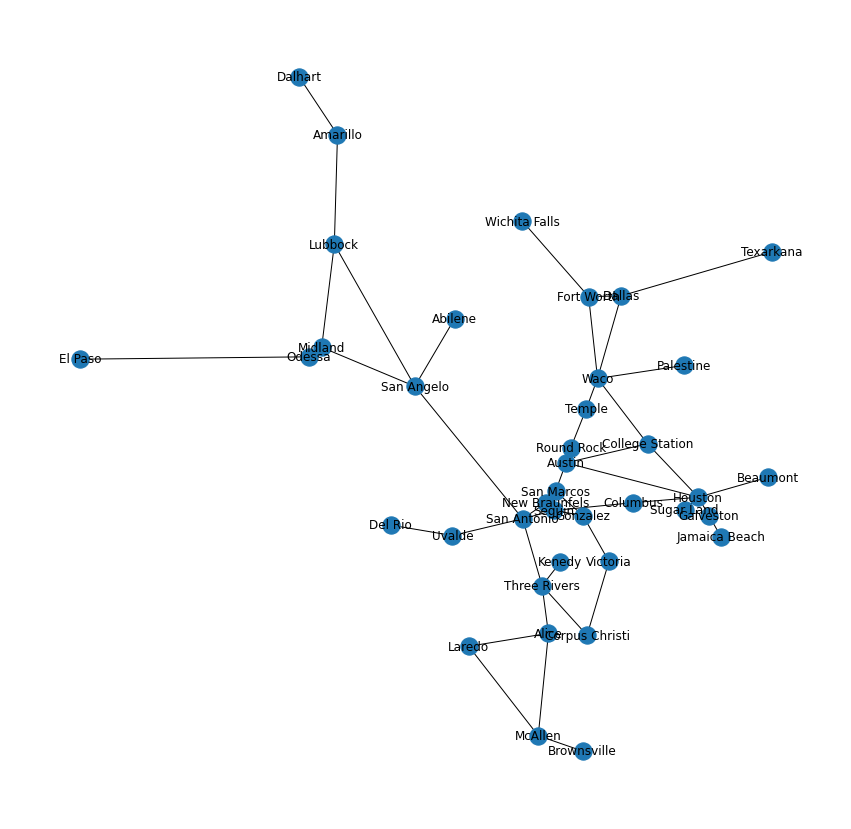

In [162]:
# Load the graph data from the files
plot = nx.Graph()
map = Graph()
plt.figure(figsize=(15,15))
#texasMap = gp.read_file(texasPath)
#texasMap.plot()

#cityData contains nodes
with open(citiesPath) as csvfile:
  cityData = csv.reader(csvfile, delimiter=',')
  for city in cityData:
    plot.add_node(city[0], pos=(float(city[2]), float(city[1])))

#distanceData contains edges
with open(distancesPath) as csvfile:
  distanceData = csv.reader(csvfile, delimiter=',')
  for edge in distanceData:
    plot.add_edge(edge[0], edge[1], weight=float(edge[2]))
    map.add_neighbor(edge[0], edge[1], float(edge[2]))
    #print(edge)


#print(map.all_nodes['San Antonio'].all_neighbors)
nodes = nx.get_node_attributes(plot, 'pos')
edges = nx.get_edge_attributes(plot, 'weight')

nx.draw_networkx(plot, nodes, with_labels = True)

plt.axis('off')
plt.show()

#Virus Spread - Uninformed Search Agent

##(40 points)

In this section, you will use the graph created in the previous section and create an *uninformed search* agent that will print the path how the virus will spread to all the provided Texas cities. The first confirmed case of the virus was in **Three Rivers** and starts spreading from there. The virus does not discriminate and it needs to spread to all the cities of Texas.

In the following code block, write code to implement **any** uninformed search strategy. You are free to create more code blocks if needed. As the output, print

*   The path or sequence of cities that will be infected by the spread of Coronavirus.
*   The distance travelled by the selected virus spreading strategy.

##Extra Credit (3 points)
On the 2D graph and the Texas state map, overlay the selected path along with the cities visited.

In [163]:
# Implement ANY uninformed search strategy for the spread of coronavirus from the starting city of 'Three Rivers'
# BFS search algorithm as explained in lecture notes, modified to traverse entire graph
def BreadthFirstSearch(graph, start):
  frontier = []
  explored = []
  distanceTraveled = 0
  #dict of all cities. Key = city name, Value = node instance
  cities = map.all_nodes
  frontier.append(cities[start])
  #loop while frontier is not empty
  while frontier:
      node = frontier.pop(0)
      explored.append(node)
      #iterate through city names and distances of current node's neighbors
      for city, distance in node.all_neighbors.items():
          #if we haven't explored that city and haven't enqueued it, add to to frontier and add its distance to total travel
          if cities[city] not in frontier and cities[city] not in explored:
            frontier.append(cities[city])
            distanceTraveled += distance
  return explored, distanceTraveled

explored, distanceTraveled = BreadthFirstSearch(map, 'Three Rivers')

print("Sequence of Cities:")
for city in explored:
  print(city.name)
print("Distance Traveled by spreading strategy:",distanceTraveled,"mi")

Sequence of Cities:
Three Rivers
San Antonio
Corpus Christi
Alice
Kenedy
San Angelo
New Braunfels
Seguin
Uvalde
Victoria
Laredo
McAllen
Midland
Lubbock
Abilene
San Marcos
Gonzalez
Columbus
Del Rio
Brownsville
Odessa
Amarillo
Austin
Houston
El Paso
Dalhart
Round Rock
College Station
Beaumont
Galveston
Sugar Land
Temple
Waco
Jamaica Beach
Palestine
Fort Worth
Dallas
Wichita Falls
Texarkana
Distance Traveled by spreading strategy: 3354.31992298 mi


#Vaccine Transportation - Informed Search Agent

##(40 points)

In this section, you will create an *informed search* agent that will be used to transport the vaccine. The city of **San Antonio** has more supply of vaccine than the demand. The goal is to create an **optimal strategy** to transport the vaccine and make it available at the highly affected city of **College Station**, where there is a shortage of vaccines.

In the following code block, write code to implement an **optimal** informed search strategy. You are free to create more code blocks if needed. As the output, print 

*   The path / sequence of cities that will be visited in the optimal vaccine transportation strategy.
*   The total distance travelled in the optimal vaccine transportation strategy.


##Extra Credit (3 points)
On the 2D graph and the Texas state map, overlay the selected path along with the cities visited.

In [165]:
# Implement an OPTIMAL informed search strategy for distributing the vaccine from 'San Antonio' to 'College Station'

def calculateHaversineDistance(cityData, goalCity):
  heuristic = {}
  #find and save the goalCoordinate
  with open(citiesPath) as csvfile:
    cityData = csv.reader(csvfile, delimiter=',')
    for city in cityData:
      #print(city[0] + " vs " + goalCity)
      if city[0] == goalCity:
        goalCoordinate = (float(city[1]), float(city[2]))
        break

  #calculate the haversine distance between goal and every city
  with open(citiesPath) as csvfile:
    cityData = csv.reader(csvfile, delimiter=',')
    for city in cityData:
      heuristic[city[0]] = haversine((float(city[1]), float(city[2])), goalCoordinate, Unit.MILES)
  #print(heuristic)
  return heuristic


def a_star(map, heuristic, start, goal):
  frontier = PriorityQueue()
  expanded = []
  distanceTraveled = 0
  cities = map.all_nodes
  frontier.put((0+heuristic[start], cities[start],[start],0))

  #while frontier is not empty
  while frontier.qsize() != 0:
    #expand node
    # node is = ( f(n), node object, path (city names list), g(n) (cost till now) )
    node = frontier.get()
    expanded.append(node)

    #if found goal return path and distance
    if node[1].name == goal:
      return node[2], node[3]
    
    #for every neighbor connected to current node
    for neighbor in node[1].all_neighbors.items():
      #if neighbor not expanded and not in frontier
      #print(type(node[2]))
      cityObject = cities[neighbor[0]] 
      edgeWeight = neighbor[1]
      if (cities[neighbor[0]] not in expanded  and  cities[neighbor[0]] not in frontier.queue):
        # enqueue          priority = h(n) + cost up to now + edgeWeight aka step cost, neighbor node object, path to this node + this node name, cost up to this node
        temp = node[2][:]
        temp.append(neighbor[0])
        frontier.put( (heuristic[cityObject.name] + node[3] + edgeWeight, cities[neighbor[0]], temp, node[3] + edgeWeight) )
        temp = node[2][:]
  return "not found"


heuristic = calculateHaversineDistance(cityData, 'College Station')
#for key, value in heuristic.items():
#print(key, value)


path, distanceTraveled = a_star(map, heuristic, 'San Antonio', 'College Station')
print("Optimal path taken wit A*:")
for city in path:
  print(city)
print("---------")
print("Distance traveled:", distanceTraveled,"mi")

Optimal path taken wit A*:
San Antonio
New Braunfels
San Marcos
Austin
College Station
---------
Distance traveled: 186.77450141 mi


#Submission Instructions

1.   Complete all tasks above - **File MUST contain the output for ALL cells**
2.   Export this notebook as .ipynb
      (File > Download as ipynb)
3.   Upload the .ipynb file on Blackboard

##Rubric

*   (45 points) Reading Data files & Creating a 2D Graph
*   (40 points) Virus Spread - Uninformed Search Agent
*   (40 points) Vaccine Transportation - Informed Search Agent
*   (10 points) Extra Credit - on the Texas map image, overlay the 2D graph and the paths selected by the search agents



